##Import CSV file

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split

random.seed(1)

csv_path = os.path.join(".","epldata_final.csv")
player_data = pd.read_csv(csv_path)

In [2]:
player_data.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [3]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          461 non-null    object 
 1   club          461 non-null    object 
 2   age           461 non-null    int64  
 3   position      461 non-null    object 
 4   position_cat  461 non-null    int64  
 5   market_value  461 non-null    float64
 6   page_views    461 non-null    int64  
 7   fpl_value     461 non-null    float64
 8   fpl_sel       461 non-null    object 
 9   fpl_points    461 non-null    int64  
 10  region        460 non-null    float64
 11  nationality   461 non-null    object 
 12  new_foreign   461 non-null    int64  
 13  age_cat       461 non-null    int64  
 14  club_id       461 non-null    int64  
 15  big_club      461 non-null    int64  
 16  new_signing   461 non-null    int64  
dtypes: float64(3), int64(9), object(5)
memory usage: 61.4+ KB


In [4]:
#fill in null in region
player_data['region'].fillna(4, inplace=True)

##Correlation Matrix

In [5]:
correlation_matrix = player_data.corr()
correlation_matrix["market_value"].sort_values(ascending=False)

market_value    1.000000
fpl_value       0.788653
page_views      0.739657
fpl_points      0.615155
big_club        0.593483
new_signing     0.131321
region          0.099114
new_foreign     0.098056
club_id        -0.046068
age_cat        -0.117682
age            -0.132396
position_cat   -0.217637
Name: market_value, dtype: float64

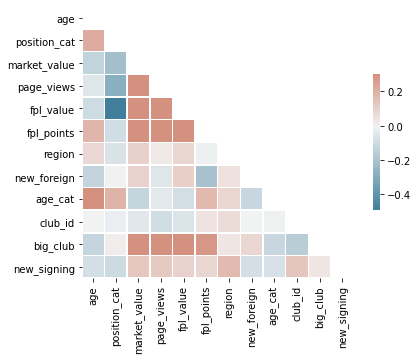

In [6]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##Data Pipeline

In [7]:
#drop name and club
player_data_unlabeled = player_data.drop(columns=['name', 'club', 'market_value'])
player_data_labeled = player_data['market_value']

#convert fpl_sel (percentage) to number
import re
for i in range(len(player_data_unlabeled['fpl_sel'])):
  num = re.findall("\d+.\d+", player_data_unlabeled['fpl_sel'][i])
  player_data_unlabeled['fpl_sel'][i] = float(num[0]) / 100

player_data_unlabeled['fpl_sel'] = player_data_unlabeled.fpl_sel.astype(float)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

numerical_features = [x for x in player_data_unlabeled.select_dtypes([np.number]).columns]
categorical_features = [x for x in player_data_unlabeled.select_dtypes([object]).columns]

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler()),
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
])

player_data_pipeline = full_pipeline.fit_transform(player_data_unlabeled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
X_train, X_test, y_train, y_test = train_test_split(player_data_pipeline, player_data_labeled, test_size=0.1, random_state=0)

##Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_predicted = lin_reg.predict(X_test)

print("score: {}".format(lin_reg.score(X_test, y_test)))

score: 0.6431159193759028


In [10]:
cv_result = cross_validate(lin_reg, X=player_data_pipeline, y=player_data_labeled, cv=5,)
print("cross validation score: {}".format(np.mean(cv_result['test_score'])))

cross validation score: 0.662855375103131


##Neural Network

In [11]:
from sklearn.neural_network import MLPRegressor
hidden_layer_list = [(100, 50, 10), (50, 10), (500), (100), (50), (20), (10)]
score = {}
for i in hidden_layer_list:
  nn = MLPRegressor(hidden_layer_sizes=i, solver='adam', random_state=1, warm_start=True, max_iter=500)
  '''
  cv_result = cross_validate(nn, X=player_data_pipeline, y=player_data_labeled, cv=5, scoring='r2')
  print("cross validation score: {}".format(np.mean(cv_result['test_score'])))
  '''
  nn.fit(X_train, y_train)
  print("layer {} -> score: {}".format(i, nn.score(X_test, y_test)))
  score[i] = nn.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer (100, 50, 10) -> score: 0.770181767730583


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer (50, 10) -> score: 0.7589196008646422


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer 500 -> score: 0.7855958204930862


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer 100 -> score: 0.8043279355696817


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer 50 -> score: 0.7899117170598504


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer 20 -> score: 0.7429723907183896
layer 10 -> score: 0.7306692277228761


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
print("best model: {} with score: {}".format(max(score, key=score.get), max(score.values())))

best model: 100 with score: 0.8043279355696817
